# CoinGame solver using multi-agent advantage actor-critic (MAA2C) with a shared classical policy and joint classical critic.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import eqmarl
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from pathlib import Path
import numpy as np

2024-02-07 17:38:11.619464: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [4]:
metrics_file = Path("./output/coingame_maa2c_quantum.json")

metrics_file.parent.expanduser().mkdir(parents=True, exist_ok=True)

In [5]:
n_actions = 4
n_agents = 2
observation_dim = 36

In [6]:
# # Shared actor.
# model_actor = generate_model_actor_classical(
#     n_actions=n_actions,
#     units=[256, 128],
#     name=f"actor-classical-shared"
#     )
# optimizer_actor = keras.optimizers.Adam(learning_rate=3e-4)

# Quantum shared actor.
model_actor = eqmarl.models.generate_model_CoinGame2_actor_quantum(
    n_layers=5,
    name=f"actor-quantum-shared",
    )
optimizer_actor = [
    keras.optimizers.Adam(learning_rate=1e-2),
    keras.optimizers.Adam(learning_rate=1e-1),
    keras.optimizers.Adam(learning_rate=1e-1),
    ]

model_actor.build((None, observation_dim))
model_actor.summary()

Model: "actor-quantum-shared"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 4, 3)             0         
 l)                                                              
                                                                 
 HybridVariationalEncodingPQ  (None, 4)                132       
 C (HybridVariationalEncodin                                     
 gPQC)                                                           
                                                                 
 observables-policy (Sequent  (None, 4)                4         
 ial)                                                            
                                                                 
Total params: 136
Trainable params: 136
Non-trainable params: 0
_________________________________________________________________


In [7]:
# # Classical critic.
# model_critic = generate_model_critic_classical(
#     units=[256, 128],
#     name=f"critic-classical-joint"
#     )
# optimizer_critic = keras.optimizers.Adam(learning_rate=3e-4)

# Quantum joint critic.
model_critic = eqmarl.models.generate_model_CoinGame2_critic_quantum_partite(
    n_agents=n_agents,
    n_layers=5,
    name=f"critic-quantum-joint",
    )
optimizer_critic = [
    keras.optimizers.Adam(learning_rate=1e-2),
    keras.optimizers.Adam(learning_rate=1e-1),
    keras.optimizers.Adam(learning_rate=1e-1),
    ]

model_critic.build((None, n_agents, observation_dim))
model_critic.summary()

Model: "critic-quantum-joint"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 2, 4, 3)          0         
 l)                                                              
                                                                 
 HybridPartiteVariationalEnc  (None, 1)                264       
 odingPQC (HybridPartiteVari                                     
 ationalEncodingPQC)                                             
                                                                 
 observables-policy (Sequent  (None, 1)                1         
 ial)                                                            
                                                                 
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________


## Training

In [8]:
gamma = 0.99
alpha = 0.001
params = {
    'domain_name': 'CoinGame-2',
    'gamma': gamma,
    'time_limit': 50,
}
env = eqmarl.environments.coin_game.vector_coin_game_make(params)

def episode_metrics_callback(env: eqmarl.environments.coin_game.CoinGameEnvironment):
    
    coins_collected = env.domain_values()[env.get_index('coins_collected')]
    own_coins_collected = env.domain_values()[env.get_index('own_coins_collected')]
    undiscounted_reward = np.sum(env.undiscounted_returns)
    discounted_reward = np.sum(env.discounted_returns)
    own_coin_rate = own_coins_collected/coins_collected if coins_collected != 0 else 0
    
    return dict(
        coins_collected=coins_collected,
        own_coins_collected=own_coins_collected,
        own_coin_rate=own_coin_rate,
        undiscounted_reward=undiscounted_reward,
        discounted_reward=discounted_reward,
    )

algo = eqmarl.algorithms.MAA2C(
    env=env,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=gamma,
    alpha=alpha,
    episode_metrics_callback=episode_metrics_callback,
    )

In [9]:
# Train models using algorithm.
reward_history, metrics_history = algo.train(n_episodes=3000)

# Save results to file.
algo.save_train_results(metrics_file, reward_history, metrics_history)

Training for 3000 episodes, press 'Ctrl+C' to terminate early


Episode 897:  30%|██▉       | 897/3000 [35:40<1:23:38,  2.39s/episode, coins_collected=18, discounted_reward=14.5, episode_reward=[9. 9.], own_coin_rate=1, own_coins_collected=18, undiscounted_reward=18]      

Terminating early at episode 897


In [10]:
# Load metrics from file.
reward_history, metrics_history = algo.load_train_results(metrics_file)

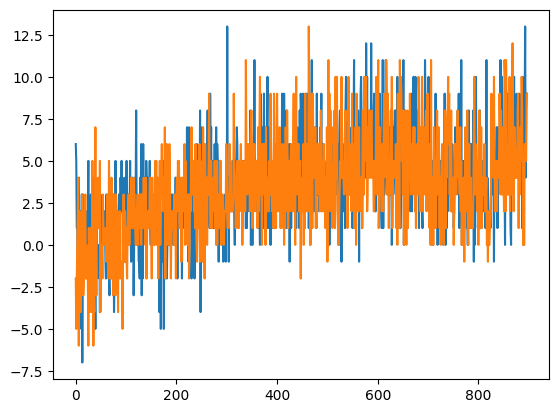

In [11]:
plt.plot(reward_history)

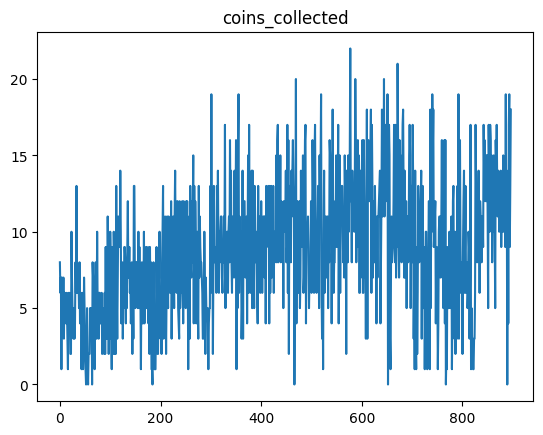

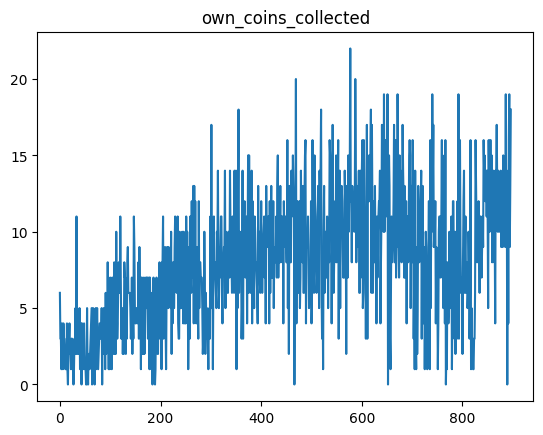

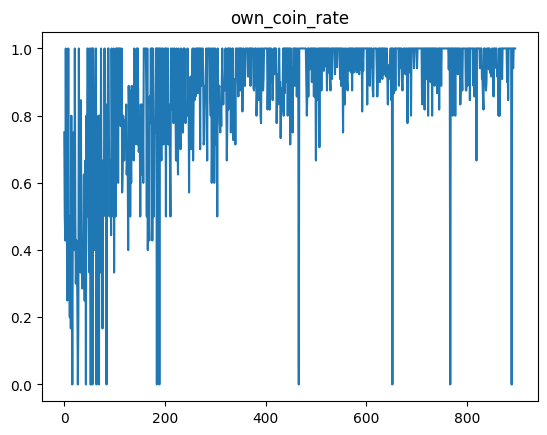

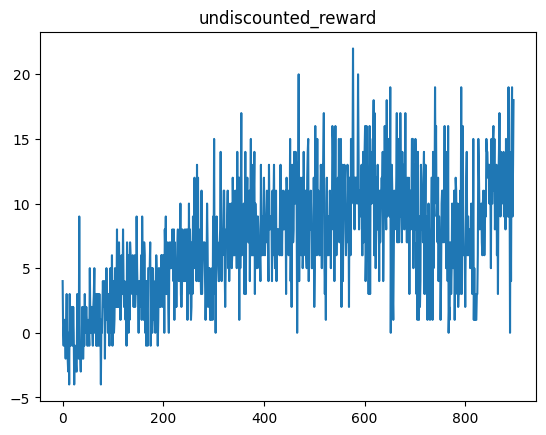

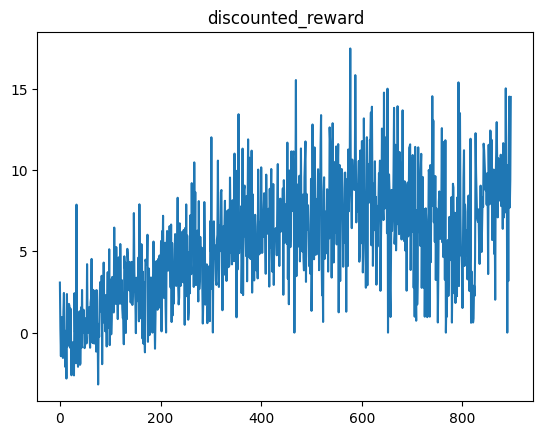

In [12]:
for k, v in metrics_history.items():
    plt.figure()
    plt.title(k)
    plt.plot(v)